In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.cm as cm


In [6]:
# Load the dataset
file = "csv_data/final3.csv"
df = pd.read_csv(file)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Preprocessing
def preprocess(df):
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Convert columns to numeric
    cols_to_convert = [
        "Family history of diabetes", "Sex of the respondent",
        "Ever diagnosed_diabetes", "Working", "Age at last birthday", "Ever diagnosed_hypertension"
    ]
    df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
    df.dropna(inplace=True)

    # Replace 2 with 0 in "Ever diagnosed_diabetes" and "Ever diagnosed_hypertension"
    df["Ever diagnosed_diabetes"].replace({2: 0}, inplace=True)
    df["Ever diagnosed_hypertension"].replace({2: 0}, inplace=True)

    return df

df = preprocess(df)

In [8]:
# Separate data for males and females
df_male = df[df["Sex of the respondent"] == 1]
df_female = df[df["Sex of the respondent"] == 2]

# Gender-Specific Analysis
def gender_analysis(df_gender, gender_name, condition_col):
    print(f"\n### Analysis for {gender_name} ({condition_col.replace('_', ' ').capitalize()}) ###\n")

    # Total count
    total = len(df_gender)
    condition_count = df_gender[condition_col].sum()

    print(f"Total {gender_name}: {total}")
    print(f"With {condition_col}: {condition_count} ({(condition_count / total) * 100:.2f}%)")

    # Working Status and Condition
    working_status = df_gender.groupby("Working")[condition_col].mean()
    print("\nCondition Prevalence by Working Status:")
    print(working_status)

    # Age and Condition
    df_gender["Age Group"] = pd.cut(df_gender["Age at last birthday"], bins=[0, 40, 60, 100], labels=["<40", "40-60", ">60"])
    age_group_stats = df_gender.groupby("Age Group")[condition_col].mean()
    print("\nCondition Prevalence by Age Group:")
    print(age_group_stats)

    # Family History and Condition
    if condition_col == "Ever diagnosed_diabetes":
        family_history = df_gender[df_gender["Family history of diabetes"] == 1][condition_col].mean()
        print(f"\nCondition Prevalence with Family History: {family_history:.2f}")
    else:
        family_history = None

    # Plots
    plt.figure(figsize=(10, 6))
    sns.barplot(x=working_status.index, y=working_status.values, palette="viridis")
    plt.title(f"{condition_col.replace('_', ' ').capitalize()} Prevalence by Working Status ({gender_name})")
    plt.ylabel("Prevalence")
    plt.xlabel("Working Status (1 = Working, 2 = Not Working)")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=age_group_stats.index, y=age_group_stats.values, palette="coolwarm")
    plt.title(f"{condition_col.replace('_', ' ').capitalize()} Prevalence by Age Group ({gender_name})")
    plt.ylabel("Prevalence")
    plt.xlabel("Age Group")
    plt.show()

    return working_status, age_group_stats, family_history


### Diabetes Analysis ###

### Analysis for Males (Ever diagnosed diabetes) ###

Total Males: 6884
With Ever diagnosed_diabetes: 1301.0 (18.90%)

Condition Prevalence by Working Status:
Working
1.0    0.145612
2.0    0.271501
Name: Ever diagnosed_diabetes, dtype: float64

Condition Prevalence by Age Group:
Age Group
<40      0.000000
40-60    0.148102
>60      0.246604
Name: Ever diagnosed_diabetes, dtype: float64

Condition Prevalence with Family History: 0.35


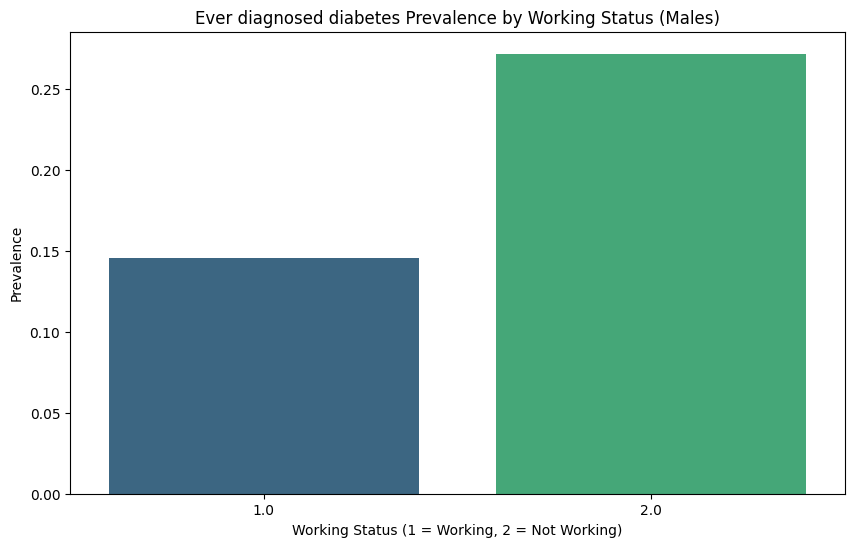

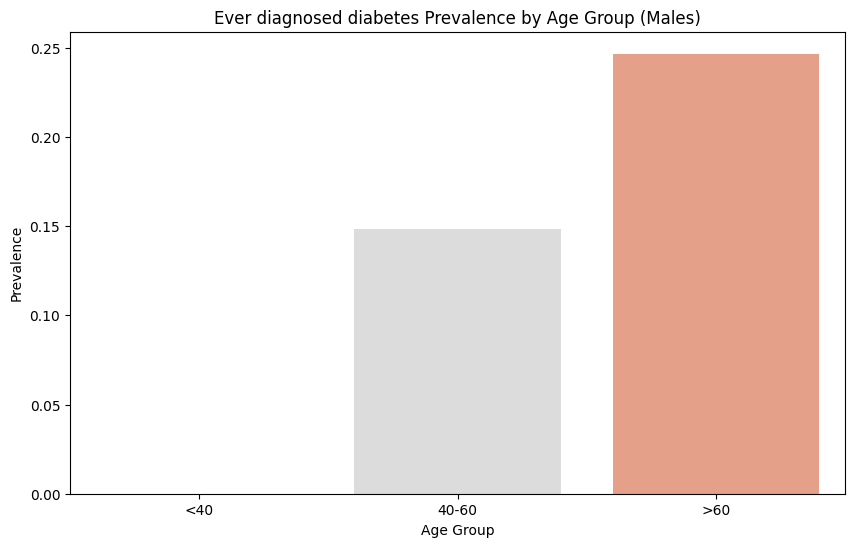


### Analysis for Females (Ever diagnosed diabetes) ###

Total Females: 5239
With Ever diagnosed_diabetes: 586.0 (11.19%)

Condition Prevalence by Working Status:
Working
1.0    0.071735
2.0    0.178048
Name: Ever diagnosed_diabetes, dtype: float64

Condition Prevalence by Age Group:
Age Group
<40      0.028902
40-60    0.098917
>60      0.201770
Name: Ever diagnosed_diabetes, dtype: float64

Condition Prevalence with Family History: 0.16


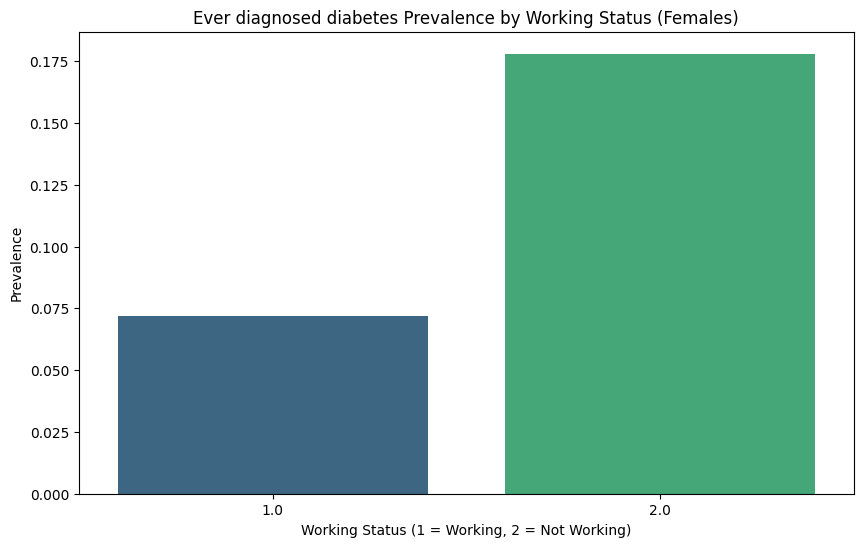

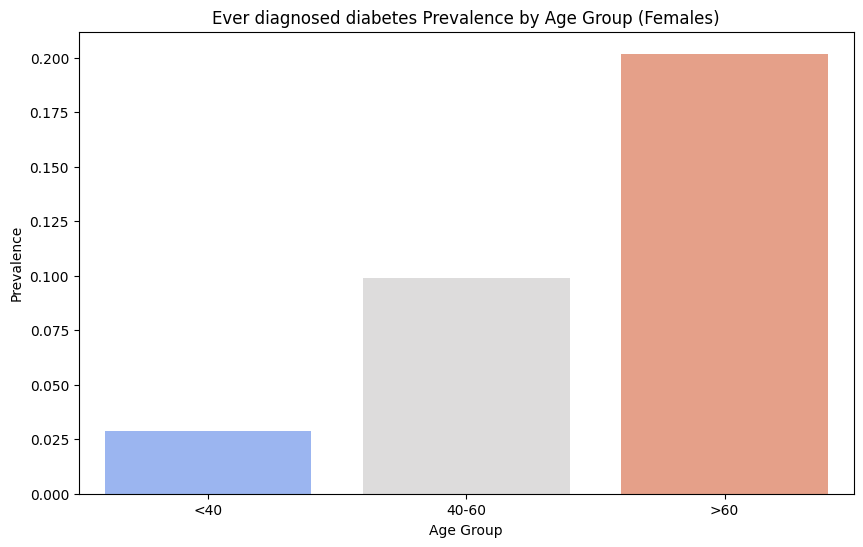

In [9]:
# Perform Analysis for Males and Females
print("### Diabetes Analysis ###")
male_diabetes = gender_analysis(df_male, "Males", "Ever diagnosed_diabetes")
female_diabetes = gender_analysis(df_female, "Females", "Ever diagnosed_diabetes")

In [10]:
# Combined Analysis
def combined_analysis(df_gender, gender_name, condition_col):
    print(f"\n### Combined Analysis for {gender_name} ({condition_col.replace('_', ' ').capitalize()}) ###\n")

    # Combined Effect of Working and Living Location
    combined_work_location = df_gender.groupby(["Working", "Place of birth-village/town"])[condition_col].mean()
    print("\nCondition Prevalence by Working Status and Living Location:")
    print(combined_work_location)

    # Combined Effect of Working, Living Location, and Family History
    if condition_col == "Ever diagnosed_diabetes":
        combined_work_location_family = df_gender.groupby(["Working", "Place of birth-village/town", "Family history of diabetes"])[condition_col].mean()
        print("\nCondition Prevalence by Working Status, Living Location, and Family History:")
        print(combined_work_location_family)

    # Combined Effect of Age Group, Working, and Living Location
    df_gender["Age Group"] = pd.cut(df_gender["Age at last birthday"], bins=[40, 60, 80, 100], labels=["40-60", "60-80", ">80"])
    combined_age_work_location = df_gender.groupby(["Age Group", "Working", "Place of birth-village/town"])[condition_col].mean()
    print("\nCondition Prevalence by Age Group, Working Status, and Living Location:")
    print(combined_age_work_location)

    # Heatmap Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(combined_work_location.unstack(), annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{condition_col.replace('_', ' ').capitalize()} Prevalence by Work & Living Location ({gender_name})")
    plt.xlabel("Place of Birth (1 = Village, 2 = Town)")
    plt.ylabel("Working Status (1 = Working, 2 = Not Working)")
    plt.show()



### Combined Analysis for Males (Ever diagnosed diabetes) ###


Condition Prevalence by Working Status and Living Location:
Working  Place of birth-village/town
1.0      1.0                            0.136699
         2.0                            0.177485
2.0      1.0                            0.250552
         2.0                            0.339286
Name: Ever diagnosed_diabetes, dtype: float64

Condition Prevalence by Working Status, Living Location, and Family History:
Working  Place of birth-village/town  Family history of diabetes
1.0      1.0                          1                             0.252747
                                      2                             0.288210
                                      3                             0.264286
                                      4                             0.218182
                                      5                             0.416667
                                      6                             

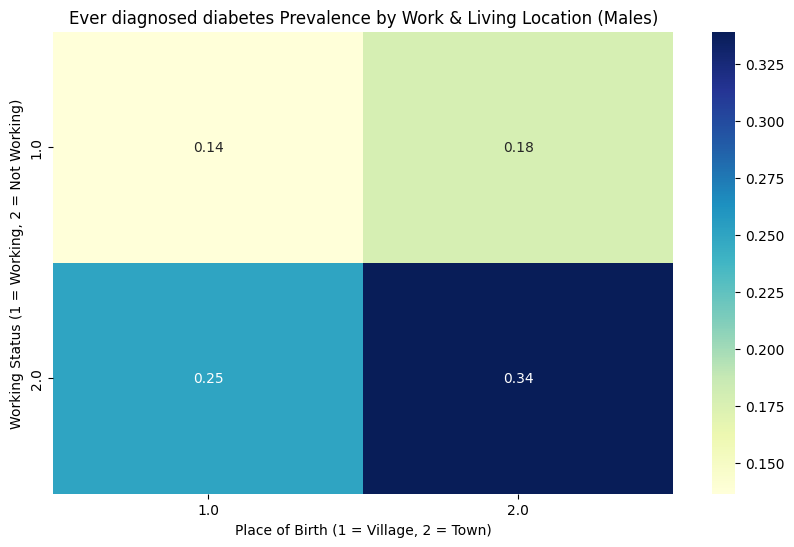


### Combined Analysis for Females (Ever diagnosed diabetes) ###


Condition Prevalence by Working Status and Living Location:
Working  Place of birth-village/town
1.0      1.0                            0.068276
         2.0                            0.086743
2.0      1.0                            0.176712
         2.0                            0.181818
Name: Ever diagnosed_diabetes, dtype: float64

Condition Prevalence by Working Status, Living Location, and Family History:
Working  Place of birth-village/town  Family history of diabetes
1.0      1.0                          1                             0.090909
                                      2                             0.141176
                                      3                             0.086022
                                      4                             0.148936
                                      5                             0.125000
                                      7                           

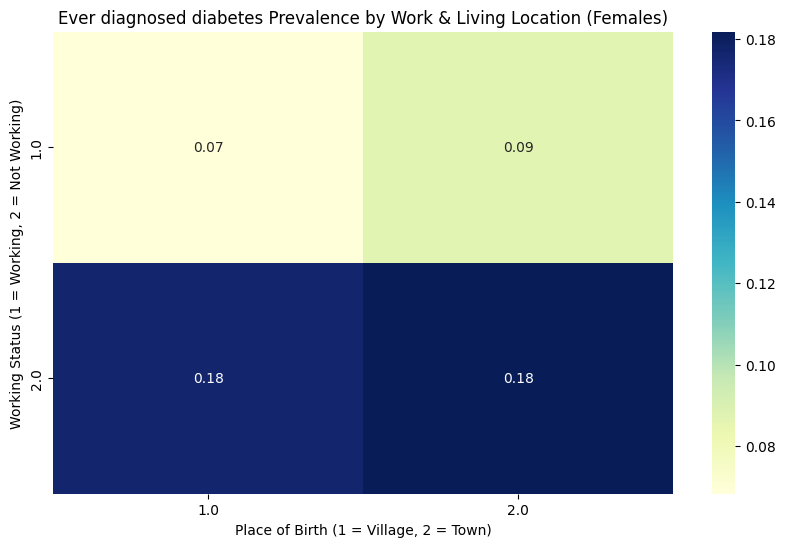

In [11]:
# # Perform Combined Analysis for Males and Females
combined_analysis(df_male, "Males", "Ever diagnosed_diabetes")
combined_analysis(df_female, "Females", "Ever diagnosed_diabetes")

In [12]:
# Aggregate Data for Heatmap
def aggregate_state_data(df_gender, condition_col):
    return (
        df_gender.groupby("State")[condition_col]
        .mean()
        .reset_index()
        .rename(columns={condition_col: "Prevalence"})
    )

In [13]:
male_diabetes = aggregate_state_data(df_male, "Ever diagnosed_diabetes")
female_diabetes = aggregate_state_data(df_female, "Ever diagnosed_diabetes")

In [14]:
india_map = gpd.read_file("india-polygon.shp")


In [15]:
# Merge Male and Female Data with India Shapefile
def merge_with_map(india_map, data, col_name):
    # Create a copy of the map
    merged_map = india_map.copy()

    # Normalize state names to handle potential variations
    def normalize_state_name(name):
        # Add any necessary name mappings here
        name_mappings = {
            'Jammu & Kashmir': 'Jammu and Kashmir',
            'Jammu and Kashmir': 'Jammu and Kashmir',
            'NCT of Delhi': 'Delhi'
        }
        return name_mappings.get(name, name)

    # Normalize state names in both datasets
    merged_map['st_nm'] = merged_map['st_nm'].apply(normalize_state_name)
    data['State'] = data['State'].apply(normalize_state_name)

    # Merge the data
    merged_map = merged_map.merge(data, left_on="st_nm", right_on="State", how="left")

    # Fill NaN values with 0
    merged_map['Prevalence'] = merged_map['Prevalence'].fillna(0)

    return merged_map

In [16]:
india_male = merge_with_map(india_map, male_diabetes, "Male Diabetes")
india_female = merge_with_map(india_map, female_diabetes, "Female Diabetes")

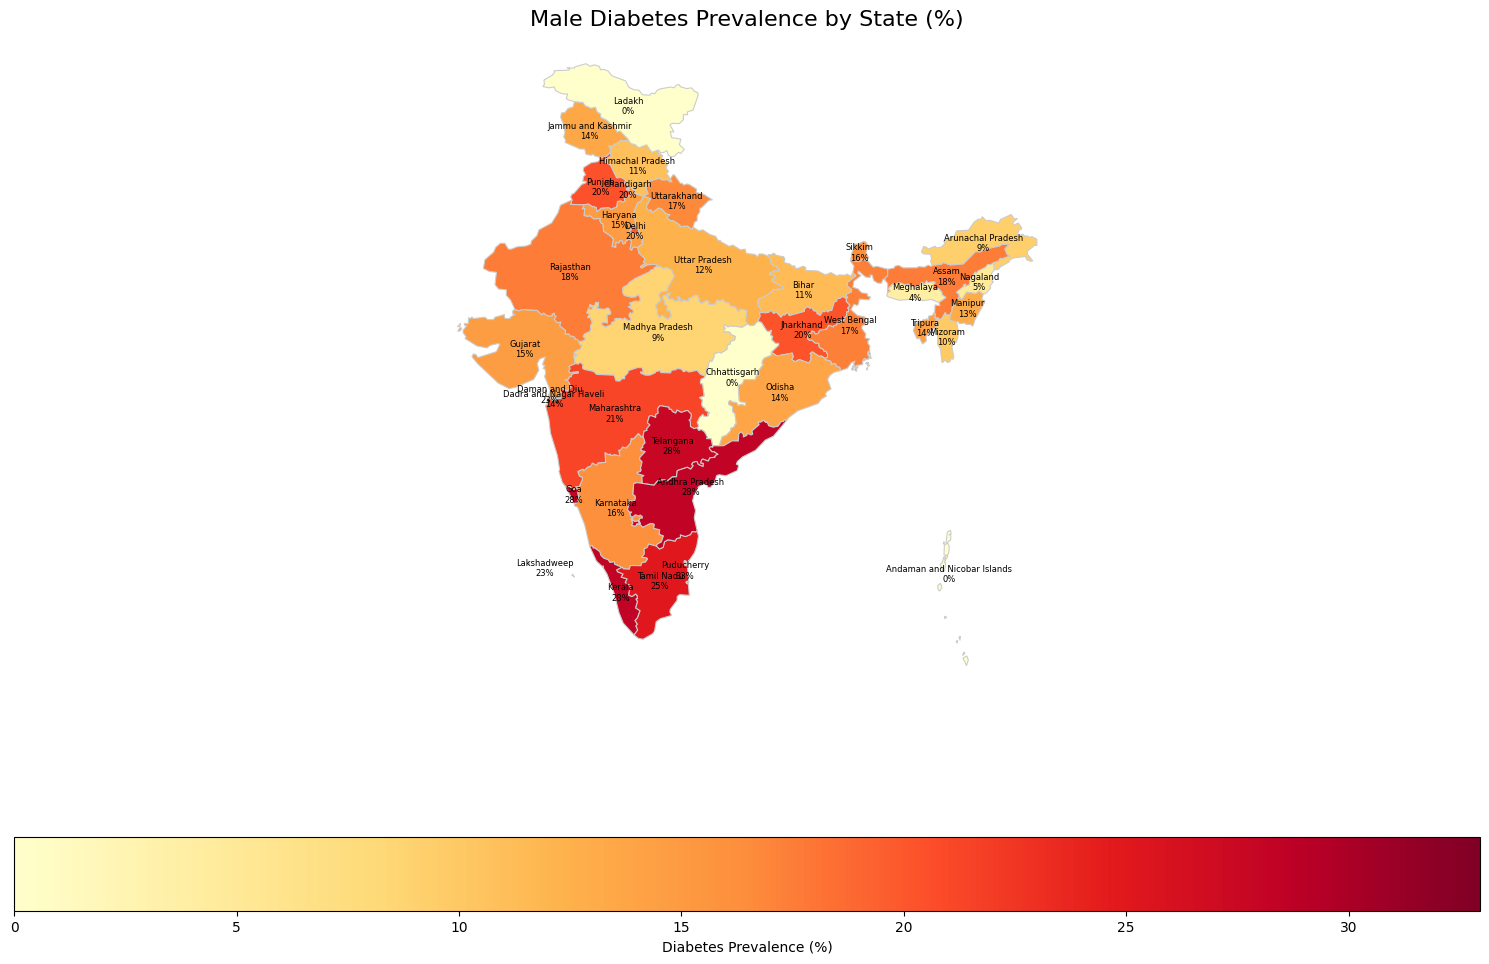

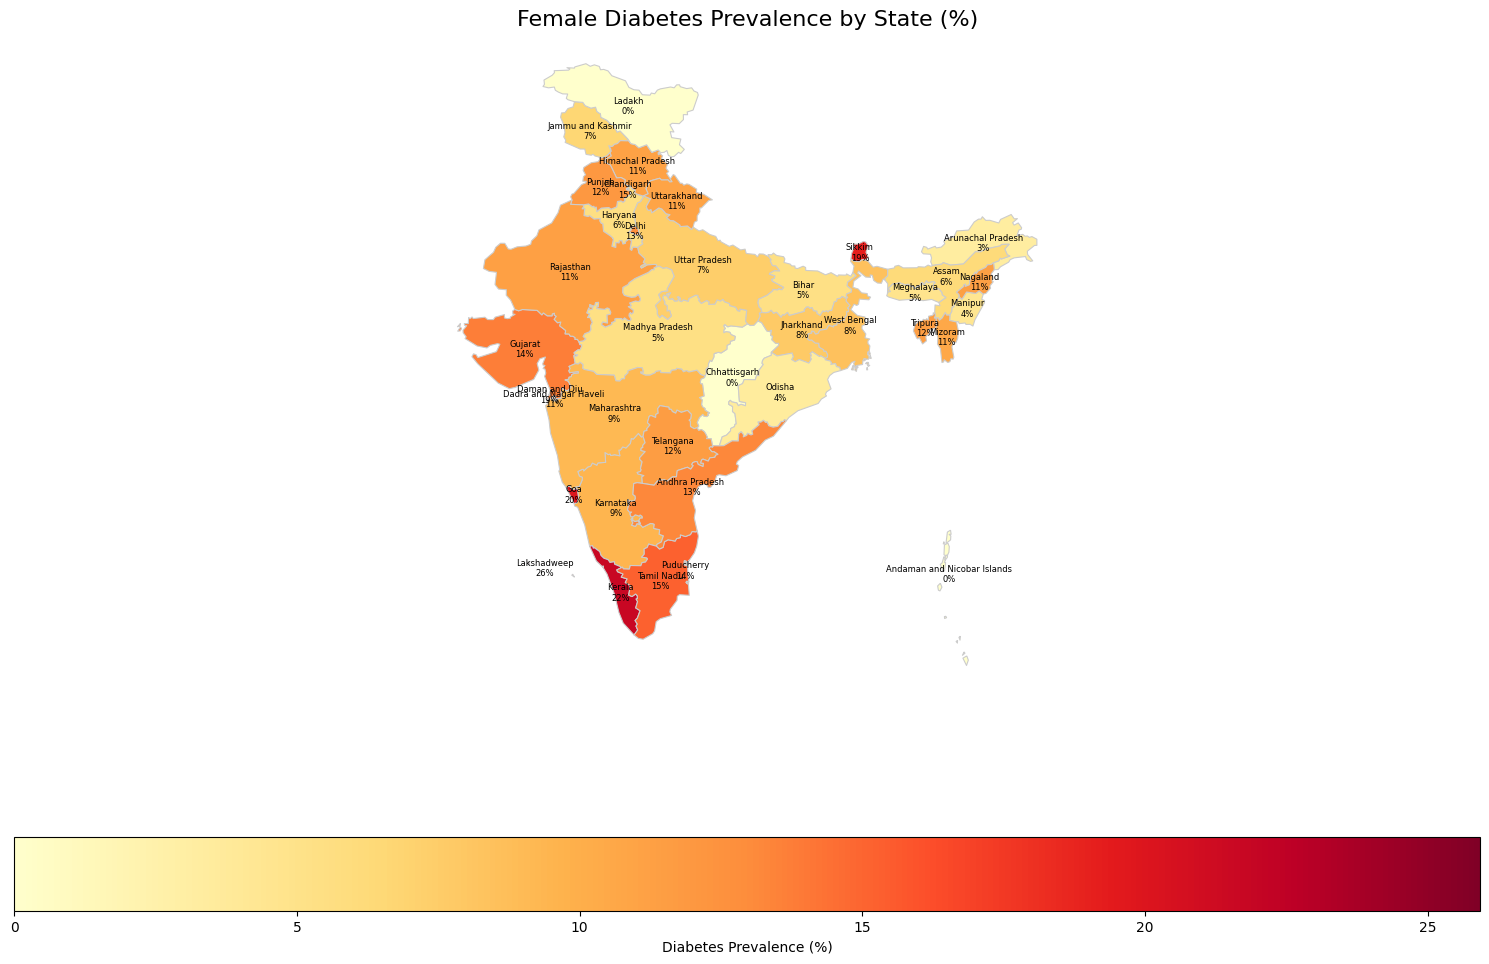

In [17]:
# Plot Heatmap with improved visualization
def plot_heatmap(india_data, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Create a custom colormap with white for zero values
    cmap = cm.YlOrRd
    cmap.set_under('white')  # Color for values below the minimum

    # Normalize the color scale
    norm = colors.Normalize(vmin=india_data['Prevalence'].min(), vmax=india_data['Prevalence'].max())

    # Plot the map
    india_data.plot(
        column="Prevalence",
        cmap=cmap,
        norm=norm,
        linewidth=0.8,
        edgecolor='0.8',
        ax=ax,
        legend=True,
        legend_kwds={
            'label': 'Diabetes Prevalence',
            'orientation': 'horizontal'
        },
        missing_kwds={
            'color': 'lightgrey'  # Color for missing data
        }
    )

    # Add state labels
    for idx, row in india_data.iterrows():
        plt.annotate(
            text=f"{row['st_nm']}\n{row['Prevalence']:.2f}",
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            va='center',
            fontsize=6
        )

    ax.set_title(title, fontdict={'fontsize': 16}, loc="center")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Updated Heatmap Function
def plot_heatmap_with_percentage(india_data, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Create a custom colormap with white for zero values
    cmap = cm.YlOrRd
    cmap.set_under('white')  # Color for values below the minimum

    # Normalize the color scale
    norm = colors.Normalize(vmin=india_data['Prevalence'].min() * 100, vmax=india_data['Prevalence'].max() * 100)

    # Convert prevalence to percentage for plotting
    india_data['Prevalence'] = india_data['Prevalence'] * 100

    # Plot the map
    india_data.plot(
        column="Prevalence",
        cmap=cmap,
        norm=norm,
        linewidth=0.8,
        edgecolor='0.8',
        ax=ax,
        legend=True,
        legend_kwds={
            'label': 'Diabetes Prevalence (%)',
            'orientation': 'horizontal'
        },
        missing_kwds={
            'color': 'lightgrey'  # Color for missing data
        }
    )

    # Add state labels with percentage values
    for idx, row in india_data.iterrows():
        plt.annotate(
            text=f"{row['st_nm']}\n{row['Prevalence']:.0f}%",
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            va='center',
            fontsize=6
        )

    ax.set_title(title, fontdict={'fontsize': 16}, loc="center")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



# Plot heatmaps with updated function
plot_heatmap_with_percentage(india_male, "Male Diabetes Prevalence by State (%)")
plot_heatmap_with_percentage(india_female, "Female Diabetes Prevalence by State (%)")


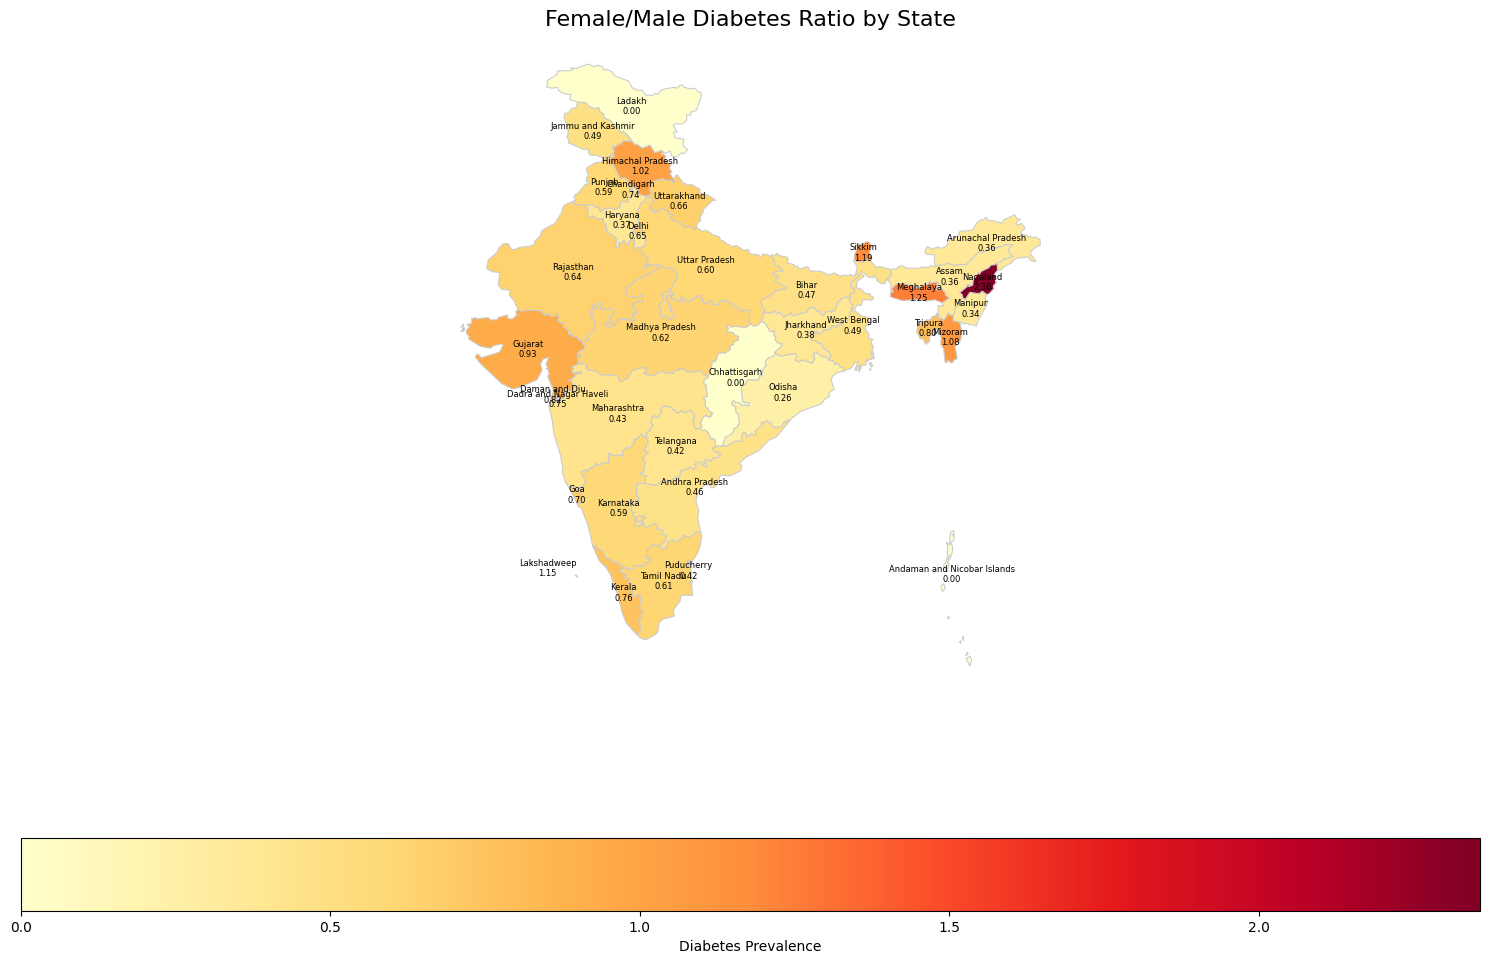

In [18]:
# Calculate Female/Male Diabetes Ratio
diabetes_ratio = female_diabetes.copy()
diabetes_ratio["Prevalence"] = ((diabetes_ratio["Prevalence"]/male_diabetes["Prevalence"])).replace(0, np.nan)
# Merge and Plot Female/Male Diabetes Ratio
india_ratio = merge_with_map(india_map, diabetes_ratio, "Female/Male Diabetes Ratio")
plot_heatmap(india_ratio, "Female/Male Diabetes Ratio by State")

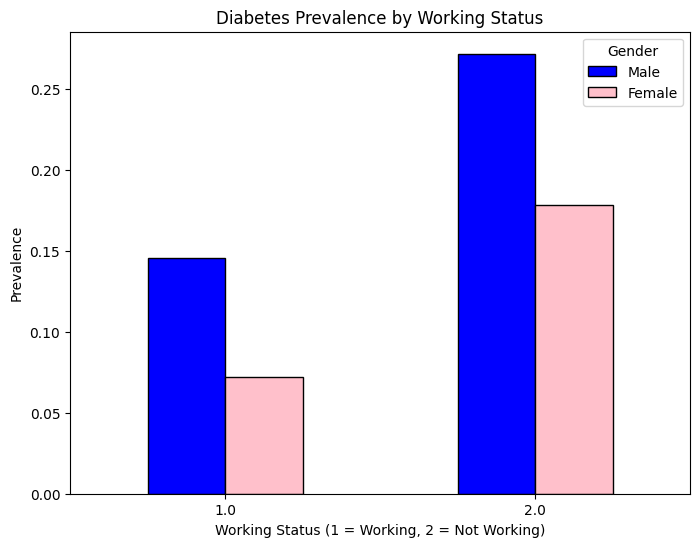

In [19]:

# Calculate Working Diabetes Ratio
working_diabetes_ratio = (
    df.groupby(["Sex of the respondent", "Working"])["Ever diagnosed_diabetes"]
    .mean()
    .unstack("Sex of the respondent")
    .rename(columns={1: "Male", 2: "Female"})
)
working_diabetes_ratio["Female/Male Ratio"] = (
    working_diabetes_ratio["Female"] / working_diabetes_ratio["Male"]
)

# Plot Working Diabetes Ratio
working_diabetes_ratio[["Male", "Female"]].plot(
    kind="bar", figsize=(8, 6), color=["blue", "pink"], edgecolor="black"
)
plt.title("Diabetes Prevalence by Working Status")
plt.ylabel("Prevalence")
plt.xlabel("Working Status (1 = Working, 2 = Not Working)")
plt.xticks(rotation=0)
plt.legend(title="Gender")
plt.show()


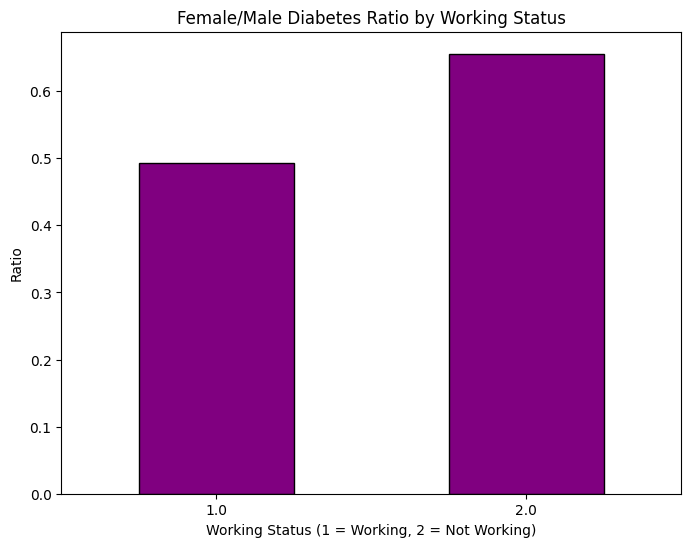

In [20]:

working_diabetes_ratio["Female/Male Ratio"].plot(
    kind="bar", figsize=(8, 6), color="purple", edgecolor="black"
)
plt.title("Female/Male Diabetes Ratio by Working Status")
plt.ylabel("Ratio")
plt.xlabel("Working Status (1 = Working, 2 = Not Working)")
plt.xticks(rotation=0)
plt.show()



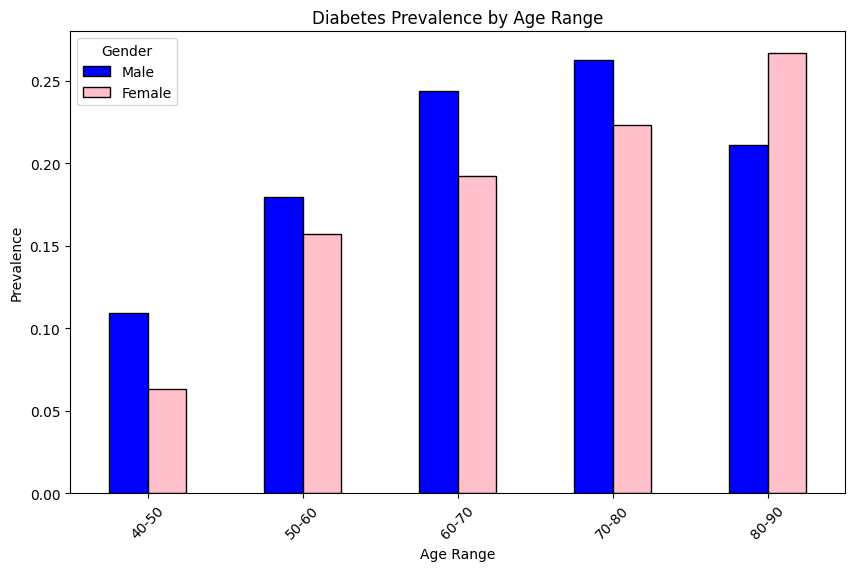

In [21]:

# Define Age Ranges
age_bins = range(40, 91, 10)
age_labels = [f"{x}-{x+10}" for x in age_bins[:-1]]
df["Age Range"] = pd.cut(df["Age at last birthday"], bins=age_bins, labels=age_labels)

# Calculate Diabetes Prevalence by Age Range
age_diabetes = (
    df.groupby(["Age Range", "Sex of the respondent"])["Ever diagnosed_diabetes"]
    .mean()
    .unstack("Sex of the respondent")
    .rename(columns={1: "Male", 2: "Female"})
)
age_diabetes["Female/Male Ratio"] = (
    age_diabetes["Female"] / age_diabetes["Male"]
)

# Plot Diabetes Prevalence by Age Range
age_diabetes[["Male", "Female"]].plot(
    kind="bar", figsize=(10, 6), color=["blue", "pink"], edgecolor="black"
)
plt.title("Diabetes Prevalence by Age Range")
plt.ylabel("Prevalence")
plt.xlabel("Age Range")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()


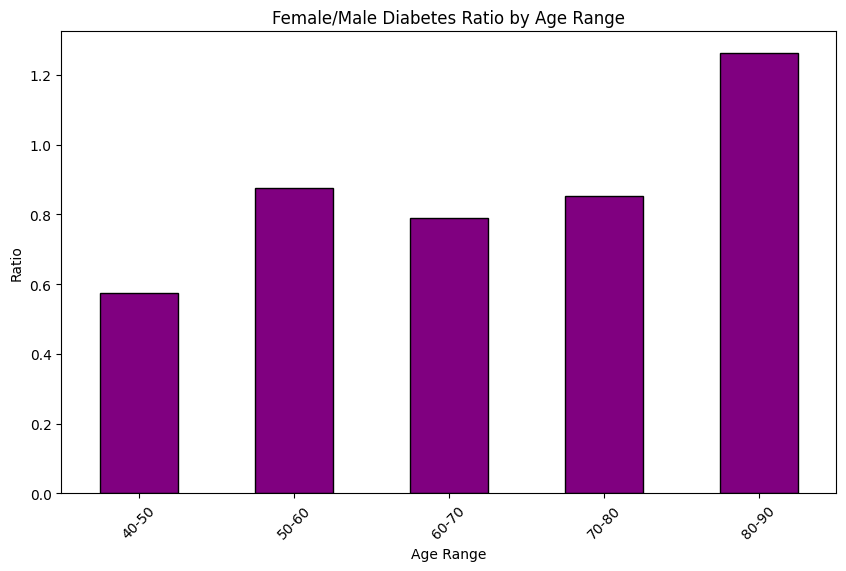

In [22]:

# Plot Female/Male Ratio by Age Range
age_diabetes["Female/Male Ratio"].plot(
    kind="bar", figsize=(10, 6), color="purple", edgecolor="black"
)
plt.title("Female/Male Diabetes Ratio by Age Range")
plt.ylabel("Ratio")
plt.xlabel("Age Range")
plt.xticks(rotation=45)
plt.show()


In [23]:
# Analysis fot Hypertension

### Hypertension Analysis ###

### Analysis for Males (Ever diagnosed hypertension) ###

Total Males: 6884
With Ever diagnosed_hypertension: 2090.0 (30.36%)

Condition Prevalence by Working Status:
Working
1.0    0.239805
2.0    0.424958
Name: Ever diagnosed_hypertension, dtype: float64

Condition Prevalence by Age Group:
Age Group
<40      0.000000
40-60    0.229271
>60      0.408220
Name: Ever diagnosed_hypertension, dtype: float64


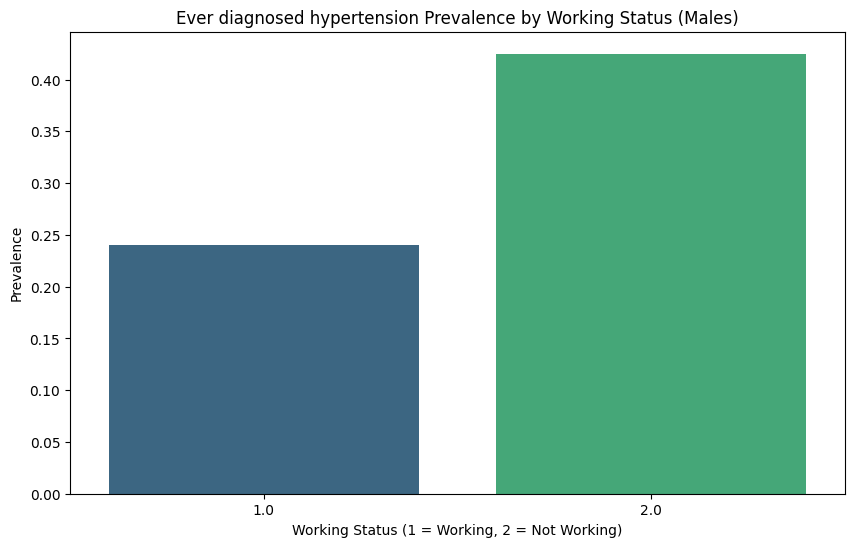

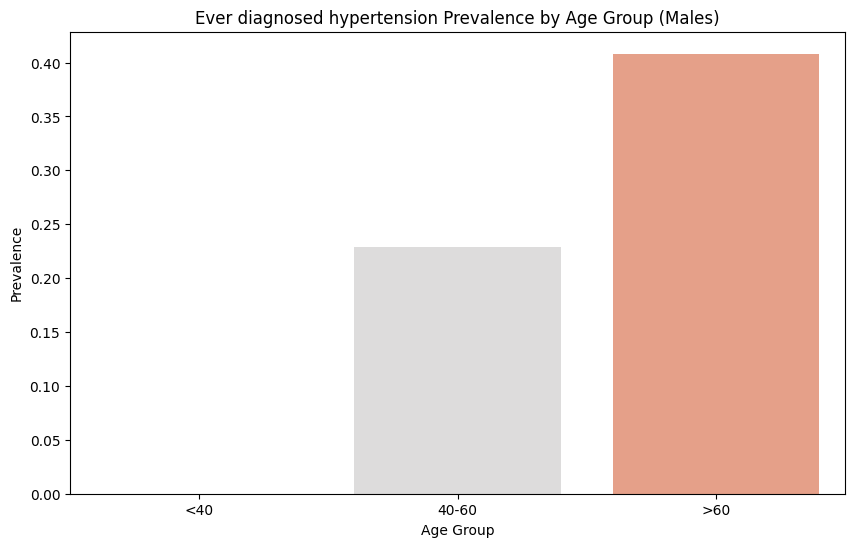


### Analysis for Females (Ever diagnosed hypertension) ###

Total Females: 5239
With Ever diagnosed_hypertension: 1525.0 (29.11%)

Condition Prevalence by Working Status:
Working
1.0    0.224709
2.0    0.400607
Name: Ever diagnosed_hypertension, dtype: float64

Condition Prevalence by Age Group:
Age Group
<40      0.131503
40-60    0.258121
>60      0.488496
Name: Ever diagnosed_hypertension, dtype: float64


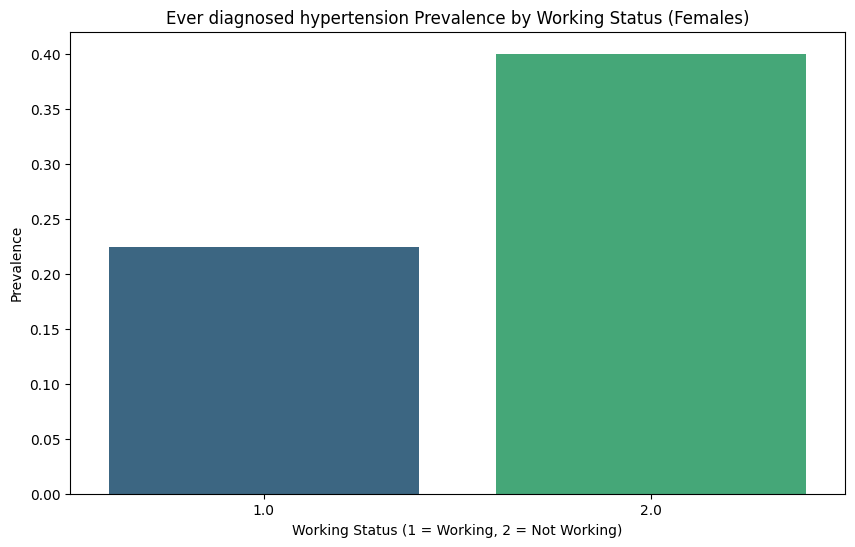

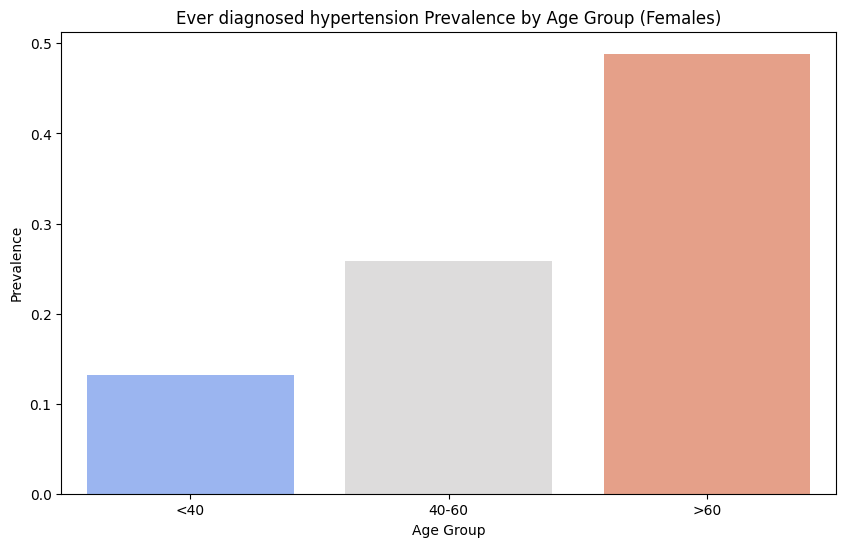

In [24]:
print("### Hypertension Analysis ###")
male_hypertension = gender_analysis(df_male, "Males", "Ever diagnosed_hypertension")
female_hypertension = gender_analysis(df_female, "Females", "Ever diagnosed_hypertension")



### Combined Analysis for Males (Ever diagnosed hypertension) ###


Condition Prevalence by Working Status and Living Location:
Working  Place of birth-village/town
1.0      1.0                            0.231707
         2.0                            0.268763
2.0      1.0                            0.417770
         2.0                            0.448214
Name: Ever diagnosed_hypertension, dtype: float64

Condition Prevalence by Age Group, Working Status, and Living Location:
Age Group  Working  Place of birth-village/town
40-60      1.0      1.0                            0.207237
                    2.0                            0.242038
           2.0      1.0                            0.325137
                    2.0                            0.358974
60-80      1.0      1.0                            0.319066
                    2.0                            0.380711
           2.0      1.0                            0.440304
                    2.0                        

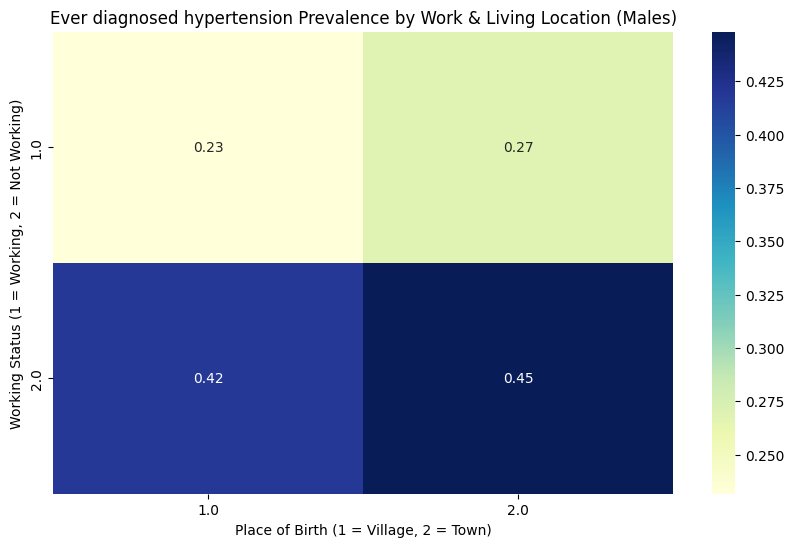


### Combined Analysis for Females (Ever diagnosed hypertension) ###


Condition Prevalence by Working Status and Living Location:
Working  Place of birth-village/town
1.0      1.0                            0.215768
         2.0                            0.263502
2.0      1.0                            0.402055
         2.0                            0.396518
Name: Ever diagnosed_hypertension, dtype: float64

Condition Prevalence by Age Group, Working Status, and Living Location:
Age Group  Working  Place of birth-village/town
40-60      1.0      1.0                            0.219775
                    2.0                            0.272527
           2.0      1.0                            0.322835
                    2.0                            0.334677
60-80      1.0      1.0                            0.364035
                    2.0                            0.436364
           2.0      1.0                            0.540070
                    2.0                      

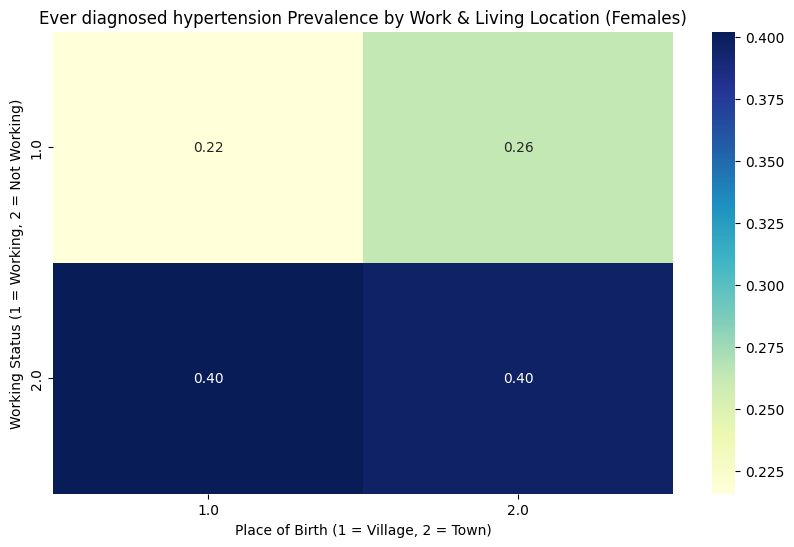

In [25]:
combined_analysis(df_male, "Males", "Ever diagnosed_hypertension")
combined_analysis(df_female, "Females", "Ever diagnosed_hypertension")

In [26]:
male_hypertension = aggregate_state_data(df_male, "Ever diagnosed_hypertension")
female_hypertension = aggregate_state_data(df_female, "Ever diagnosed_hypertension")

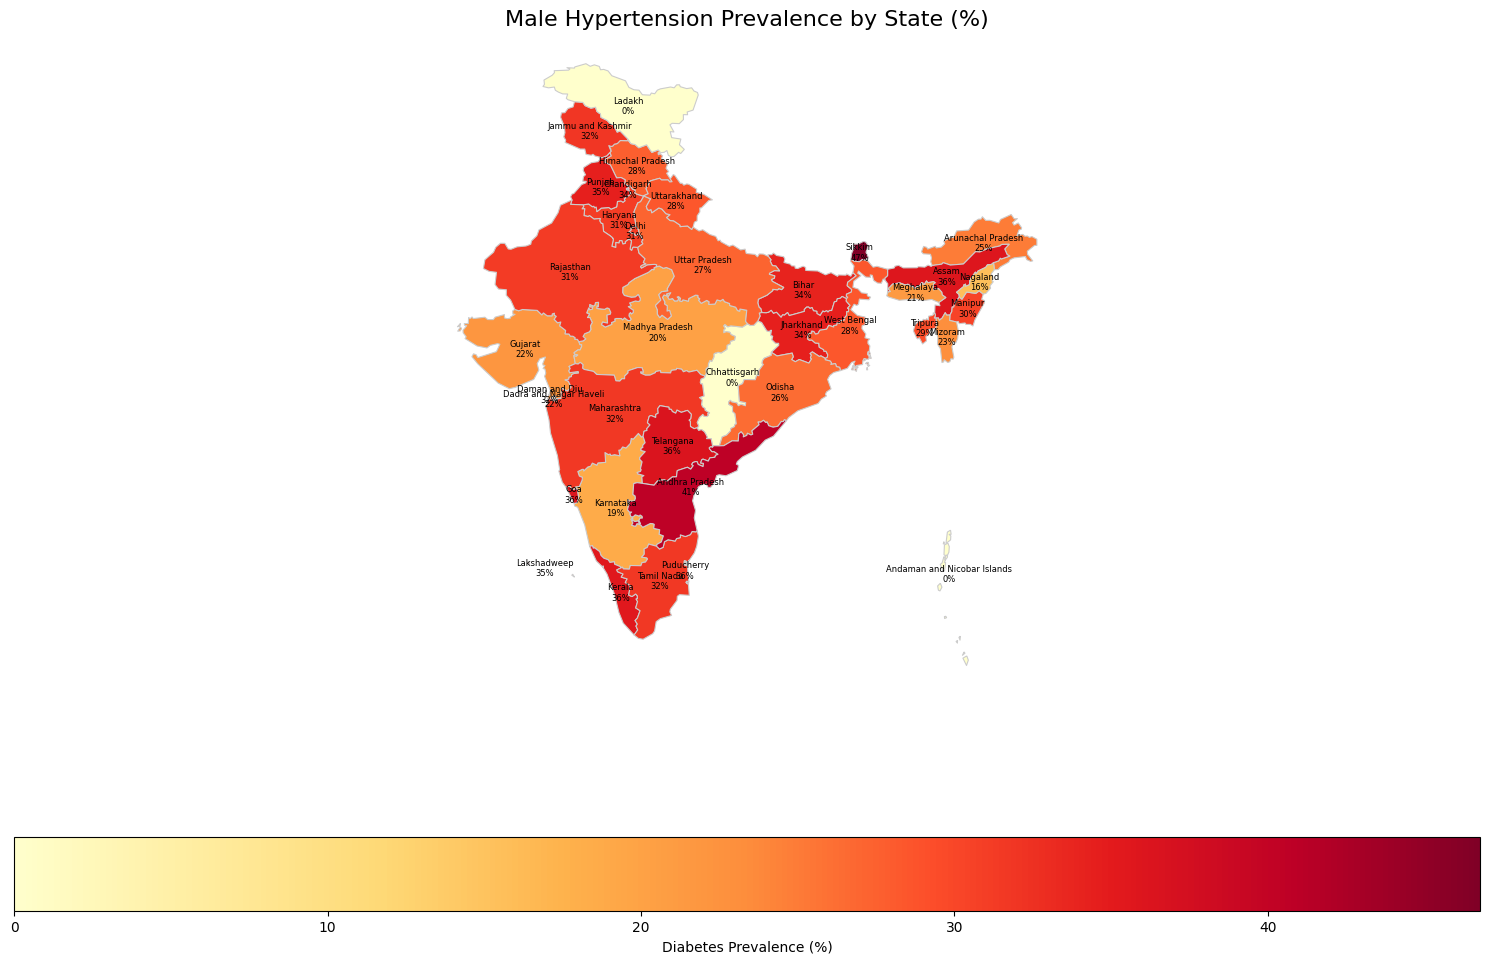

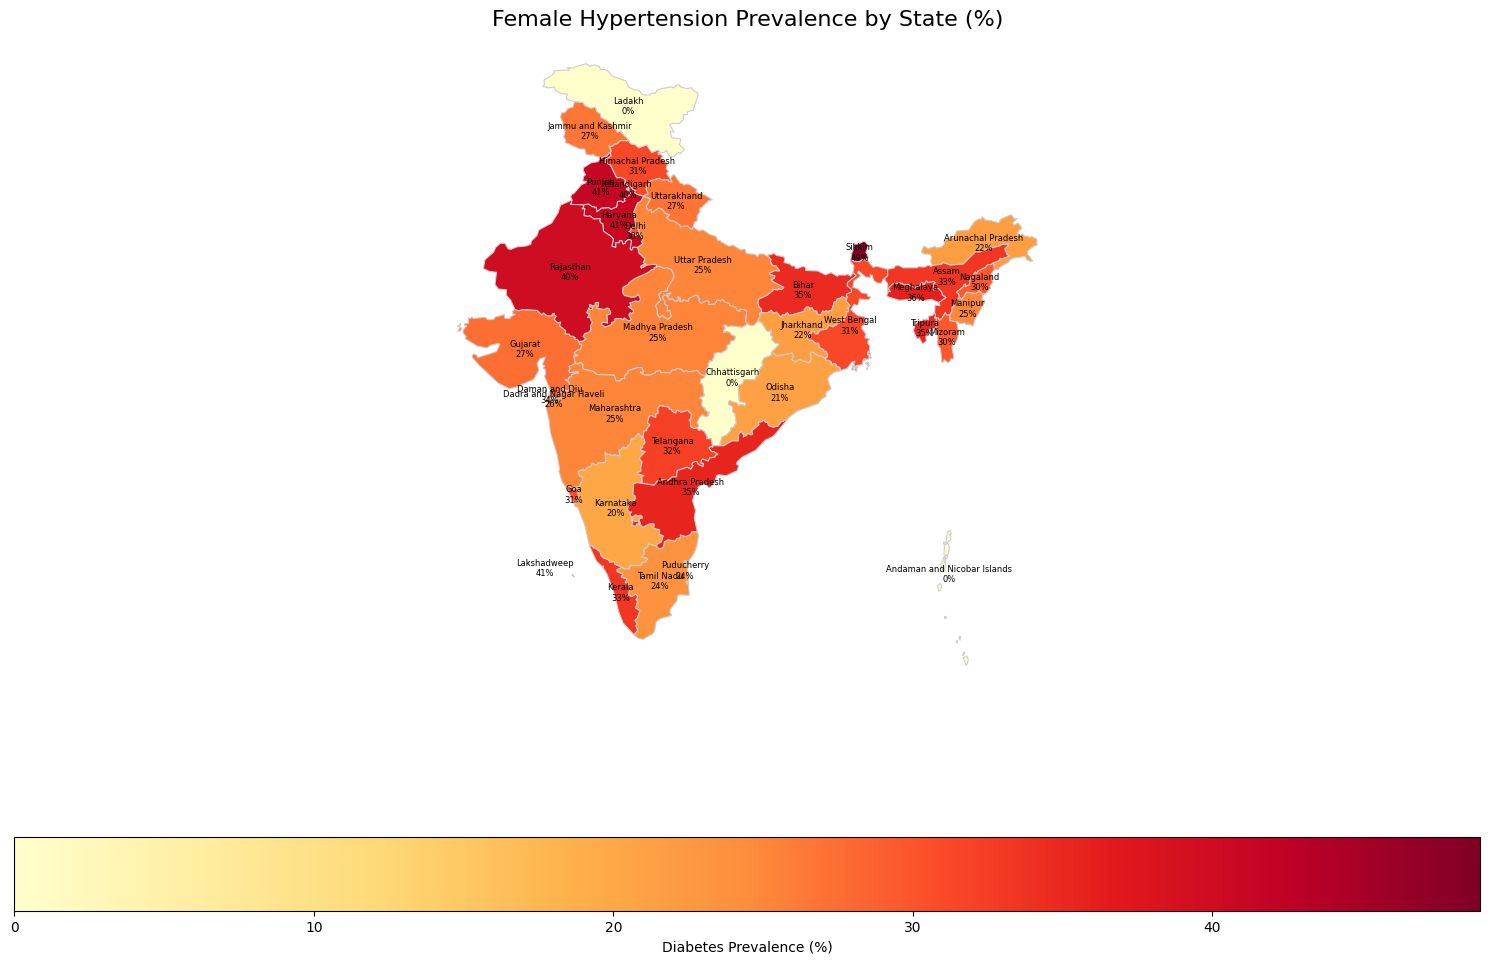

In [27]:
india_male_hypertension = merge_with_map(india_map,male_hypertension, "Male Hypertension")
india_female_hypertension = merge_with_map(india_map,female_hypertension, "Female Hypertension")

# Plot Heatmaps for Hypertension
plot_heatmap_with_percentage(india_male_hypertension,"Male Hypertension Prevalence by State (%)")
plot_heatmap_with_percentage(india_female_hypertension,"Female Hypertension Prevalence by State (%)")




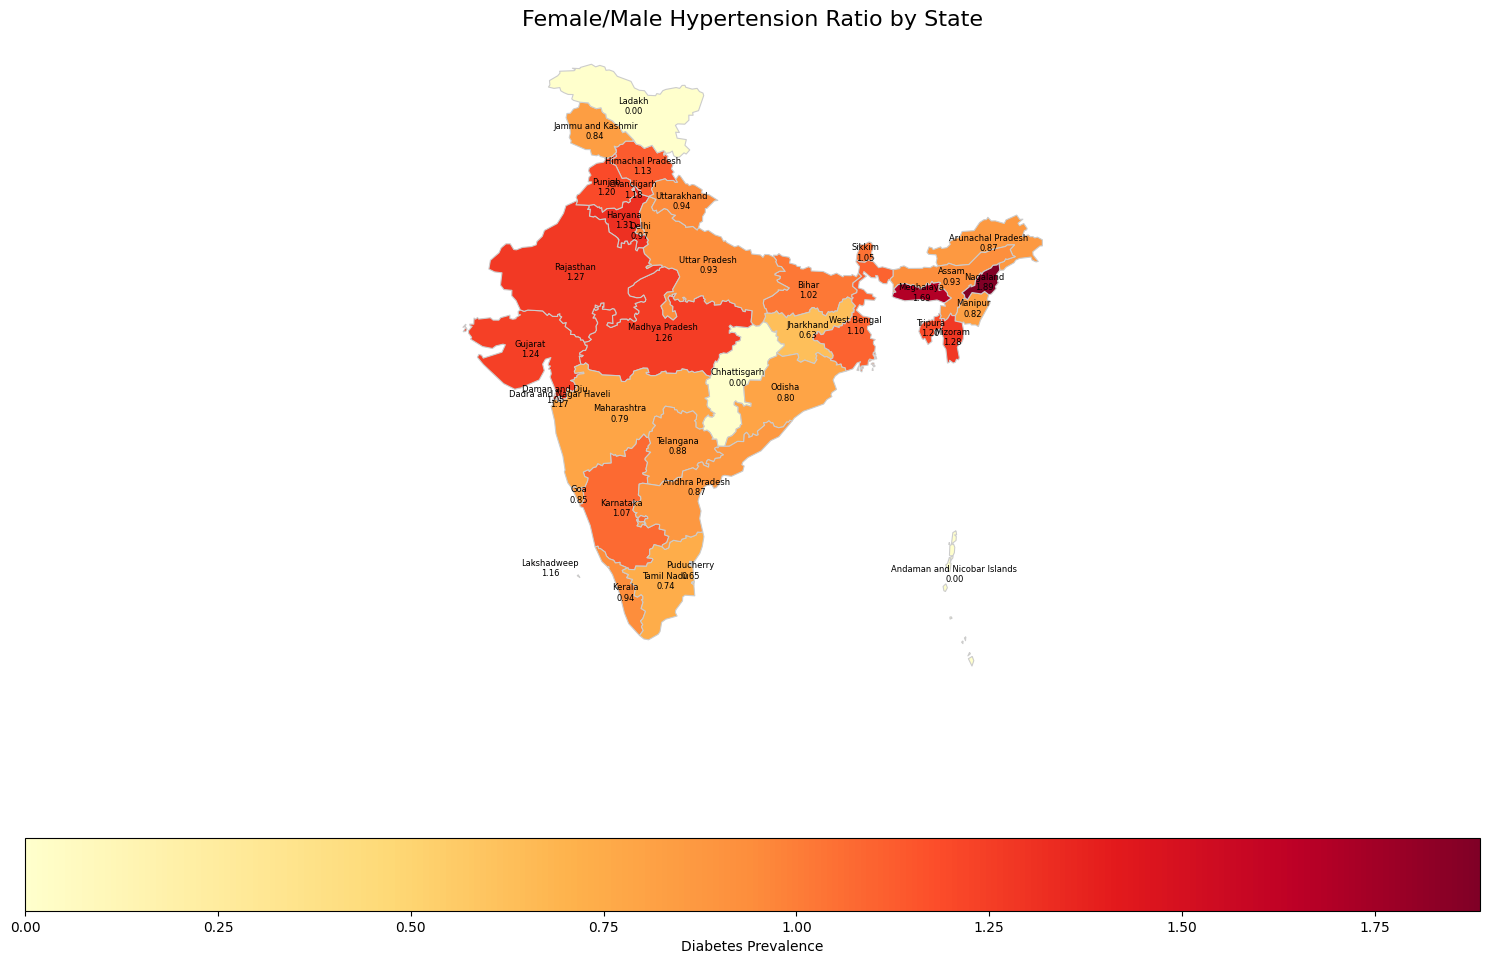

In [28]:
# Calculate Female/Male Hypertension Ratio
hypertension_ratio = female_hypertension.copy()
hypertension_ratio["Prevalence"] = ((hypertension_ratio["Prevalence"]/male_hypertension["Prevalence"])).replace(0, np.nan)
# Merge and Plot female/male hypertension Ratio
india_ratio_hyp = merge_with_map(india_map, hypertension_ratio, "Female/Male Hypertension Ratio")
plot_heatmap(india_ratio_hyp,"Female/Male Hypertension Ratio by State")

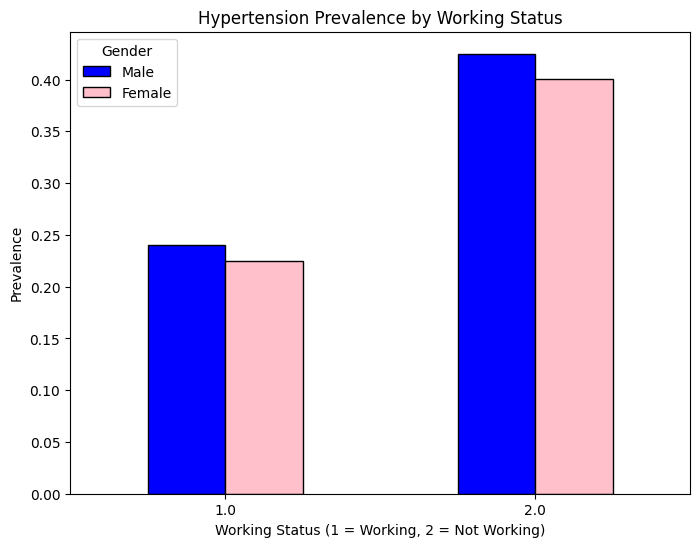

In [29]:

# Calculate Hypertension Prevalence by Age Range

# Calculate Working Diabetes Ratio
working_hypertension_ratio = (
    df.groupby(["Sex of the respondent", "Working"])["Ever diagnosed_hypertension"]
    .mean()
    .unstack("Sex of the respondent")
    .rename(columns={1: "Male", 2: "Female"})
)
working_hypertension_ratio["Female/Male Ratio"] = (
    working_hypertension_ratio["Female"] / working_hypertension_ratio["Male"]
)

# Plot Working Diabetes Ratio
working_hypertension_ratio[["Male", "Female"]].plot(
    kind="bar", figsize=(8, 6), color=["blue", "pink"], edgecolor="black"
)
plt.title("Hypertension Prevalence by Working Status")
plt.ylabel("Prevalence")
plt.xlabel("Working Status (1 = Working, 2 = Not Working)")
plt.xticks(rotation=0)
plt.legend(title="Gender")
plt.show()


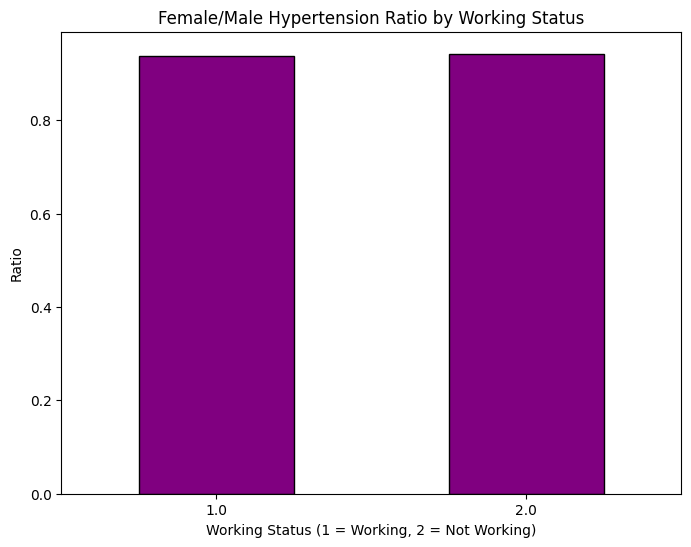

In [30]:

working_hypertension_ratio["Female/Male Ratio"].plot(
    kind="bar", figsize=(8, 6), color="purple", edgecolor="black"
)
plt.title("Female/Male Hypertension Ratio by Working Status")
plt.ylabel("Ratio")
plt.xlabel("Working Status (1 = Working, 2 = Not Working)")
plt.xticks(rotation=0)
plt.show()




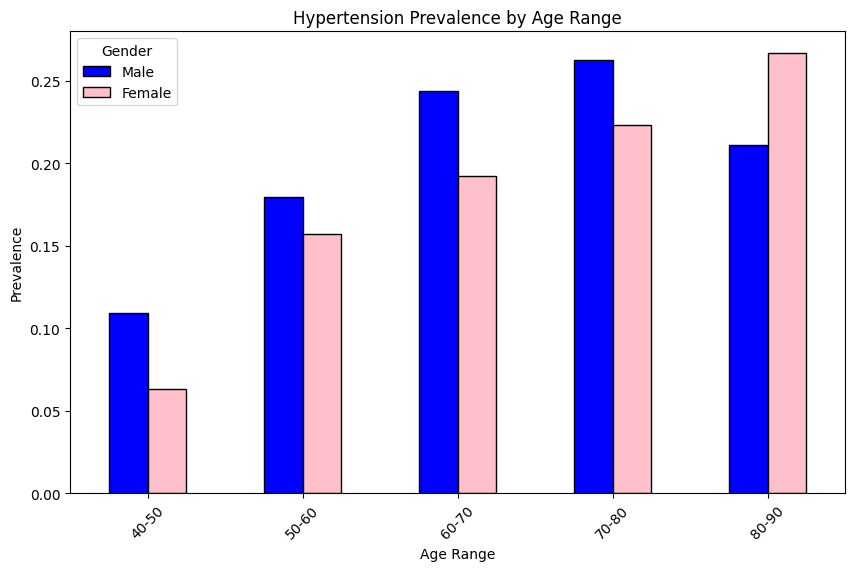

In [31]:
# Define Age Ranges
age_bins = range(40, 91, 10)
age_labels = [f"{x}-{x+10}" for x in age_bins[:-1]]
df["Age Range"] = pd.cut(df["Age at last birthday"], bins=age_bins, labels=age_labels)

# Calculate Hypertension Prevalence by Age Range
age_hypertension = (
    df.groupby(["Age Range", "Sex of the respondent"])["Ever diagnosed_diabetes"]
    .mean()
    .unstack("Sex of the respondent")
    .rename(columns={1: "Male", 2: "Female"})
)
age_hypertension["Female/Male Ratio"] = (
    age_hypertension["Female"] / age_hypertension["Male"]
)

# Plot Hypertension Prevalence by Age Range
age_hypertension[["Male", "Female"]].plot(
    kind="bar", figsize=(10, 6), color=["blue", "pink"], edgecolor="black"
)
plt.title("Hypertension Prevalence by Age Range")
plt.ylabel("Prevalence")
plt.xlabel("Age Range")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()


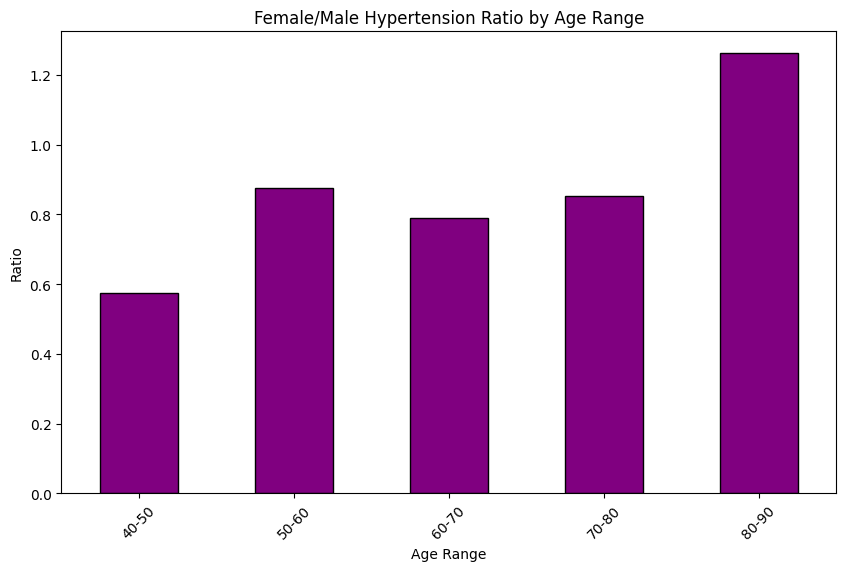

In [32]:

# Plot Female/Male Ratio by Age Range
age_hypertension["Female/Male Ratio"].plot(
    kind="bar", figsize=(10, 6), color="purple", edgecolor="black"
)
plt.title("Female/Male Hypertension Ratio by Age Range")
plt.ylabel("Ratio")
plt.xlabel("Age Range")
plt.xticks(rotation=45)
plt.show()
